Marcin Wardyński  
czwartek, 8:00

### Laboratorium 5: Klasyfikacja

Tym razem wyekstrahowałem wiele funkcji pomocniczych do zewnętrzenego pliku utils, żeby zwiększyć przejrzystość tego notatnika. Funkcje te najczęściej pojawiały się w poprzednich laboratoriach i zostały tylko trochę dopasowane na potrzeby tego laboratorium. Są to m.in. funkcje do:
- wczytywania dataset-ów i ich obróbki
- operacji na Elasticsearch, typu: zakładanie indeksu, bulk eksport danych oraz wyszukiwanie
- obliczanie NDCG z uwzględnieniem rerankera

### Przygotowanie danych

Ćwiczenie zaczynam od wczytania dobrze już nam znanego zbioru danych FIQA-PL:

In [1]:
import lab5_utils as utils

corpus, queries, qrels = utils.load_fiqa()

/Users/mwardynski/Documents/ds/_semestr_9/przetwarzanie_jezyka_naturalnego/labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#TODO check the intersection between test, validation and test. Reconsider sizes of the datasets.

Ponieważ do przygotowania danych z FIQA na potrzeby transformera potrzebuję znać używany w jego tokenizerze separator, ładuję już na tym etapie ten tokenizer i zapisuję seperator w zmiennej pomocniczej.

In [2]:
from transformers import AutoTokenizer

pl_tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
separator = pl_tokenizer.sep_token

Do zrozumienia kolejnych kroków w notatniku podam kilka decyzji, które podjąłem w sprawie przygotowanych danych:
1. korzystam z predifiniowanego podziału zapytań w zbioze FIQA na zbiory: `train`, `validation` oraz `test`.
2. Odpowiedzi z korpusu, które nie są odpowiedzią na żadne pytanie z powyższych zbiorów, również zostaną uwzglęnione.
3. Stosunek danych z klasy pozytywnej do negatywnej ustalam na 1:3.
4. W celu stworzenia klasy negatywnej, wybieram odpowiedzi na pytania, które zostały zwrócone przez Elasticsearch na zadane pytanie, lecz nie są poprawnymi odpowiedziami wg zbioru danych.

AD.1. Podjąłem taką decyzję, gdyż ostatecznie NDCG będzie porównywane z tym z lab2, a tam użyliśmy zbioru `test` z FIQA. `validation` odpowiada rozmiarem zbiorowi `test`, więc go również nie zmieniałem. W tym wypadku pozostajemy z dość sporym zbiorem `train` o wielkości 14166, `validation` i `test` mają odpowiednio 1238 i 1706 relacji pytania do odpowiedzi. Przyglądając się różnym zbiorom danych tekstowych, można zauważyć, że tak duży zbiór `train` jest częstą praktyką.

AD.2. Nie ma powodu, żeby ograniczać zbiór odpowiedzi wyłącznie do tych, które nadają się na odpowiedź, w lab2 postępowałem identycznie. Poza tym zbiory danych do treningu, walidacji i testowania budowane są w ten sposób, żeby odpowiedzi nie przenikały z jednego kroku do drugiego.

AD.3. Zgodnie z poleceniem danych z klas negatywnych ma być znacznie więcej, niż tych z klasy pozytywnej, stąd stosunek 1:3. Ponieważ FIQA zawiera tylko prawdziwe relacje pomiędzy zapytaniami i korpusem, elementy z klasy negatywnej tworzę sam. Więcej o tym procesie w kolejnym punkcie.

AD.4. Ostatecznie trenowany transformer ma pełnić funkcję rerankera w pipeline FTS. Skoro taki jest jego cel, to budując dane treningowe należy skupić się na właśnie takim przypadku i już w trakcie treningu wskazywać transformerowi wśród dokumentów wysoko ocenianych przez FTS, które z nich faktycznie są poprawnymi odpowiedziami, a które nie. W związku z tym, już na etapie budowania zbiorów danych dla treningu i walidacji modelu językowego posiłkuję się różnymi indeksami Elasticsearch i do klasy negatywnej wybieram wysoko-punktowane odpowiedzi Elasticsearch.  
Zdaję sobie sprawę, że syntaktycznie odpowiedzi te będą podobne do siebie i istnieje ryzyko, że przy dość małym zbiorze danych jakim dysponujemy, oraz małej bazowej wersji użytego transformera, nauka nie przyniesie pożądanych wyników, jednakże samo podejście wydaje mi się prawidłowym dla rozważanego przypadku użycia transformera jako reranker.

Znając podstawowe założenia możemy kontynuować, zaczynam od budowy indeksu dla danych treningowych, który wyklucza odpowiedzi pojawiające się dla pytań z zbiorów `validation` oraz `test`:

In [3]:

vate_query_to_corpus_dict = utils.prepare_fiqa_qrels(qrels, ['validation', 'test'])
no_vate_corpus_dict = utils.prepare_fiqa_corpus_related_to_selected_subsets(corpus, vate_query_to_corpus_dict, False)

In [4]:
train_index_name = "mw_nlp_lab5_train"
fts_url, train_index_url = utils.create_fts_index(train_index_name)
utils.bulk_load(fts_url, train_index_name, no_vate_corpus_dict)

Index 'mw_nlp_lab5_train' deleted successfully.
Index created.
All documents indexed successfully.


To samo co wyżej, tylko tym razem dla zbioru walidacyjnego:

In [5]:
va_query_to_corpus_dict = utils.prepare_fiqa_qrels(qrels, ['validation'])
va_corpus_dict = utils.prepare_fiqa_corpus_related_to_selected_subsets(corpus, va_query_to_corpus_dict, True)

validation_index_name = "mw_nlp_lab5_validation"
fts_url, validation_index_url = utils.create_fts_index(validation_index_name)
utils.bulk_load(fts_url, validation_index_name, va_corpus_dict)

Index 'mw_nlp_lab5_validation' deleted successfully.
Index created.
All documents indexed successfully.


Mając odpowiednie dane wyizolowane i poindeksowane w Elasticsearch, przygotowuję funkcje pomocnicze do zbudowania krotek w formacie odpowiadającym transformerowi:

In [39]:
from datasets import Dataset
import random

def collect_training_dataset(index_url, corpus_dict, subsets, separator):
    query_to_corpus_dict = utils.prepare_fiqa_qrels(qrels, subsets)
    queries_dict = utils.prepare_fiqa_queries_for_selected_subset(queries, query_to_corpus_dict)

    results = []

    for q_id, q_text in queries_dict.items():
        collect_passages_for_query(q_id, q_text, corpus_dict, query_to_corpus_dict, index_url, results, separator)

    return Dataset.from_list(results)

def collect_passages_for_query(q_id, q_text, p_dict, q_to_p_dict, index_url, results, separator):
    q_p_ids = list(q_to_p_dict[q_id].keys())

    for q_p_id in q_p_ids:
        results.append(convert_to_json(q_text, p_dict[q_p_id], 1, separator))
        
    fts_results = utils.find_for_phrase_with_exclusion(index_url, q_text, 'text', 50, q_p_ids)
    fts_results_keys = list(fts_results.keys())
    for fts_result_id in random.sample(fts_results_keys, min(3*len(q_p_ids), len(fts_results_keys))):
        results.append(convert_to_json(q_text, p_dict[fts_result_id], 0, separator))

def convert_to_json(q_text, p_text, label, separator):
    return {
            "text": f"{q_text}{separator}{p_text}",
            "label": label,
        }
        

Po czym używam tych funkcji do zbudowania dataset-ów dla etapu trenowania i walidacji transformera. Zbudowane zbiory umieszczam w słowniku zbiorów, a ponieważ sam proces ich przygotowania był trochę pracochłonny, zapisuję gotowe zbiory na dysku.

In [40]:
train_dataset = collect_training_dataset(train_index_url, no_vate_corpus_dict, ['train'], separator)

In [41]:
validation_dataset = collect_training_dataset(validation_index_url, va_corpus_dict, ['validation'], separator)

In [42]:
from datasets import DatasetDict

datasets = DatasetDict({"train": train_dataset, "validation": validation_dataset})
datasets.save_to_disk("./question-passage-classification")




Saving the dataset (1/1 shards): 100%|██████████| 56552/56552 [00:00<00:00, 627217.98 examples/s]


Saving the dataset (1/1 shards): 100%|██████████| 4942/4942 [00:00<00:00, 163086.16 examples/s]


### Przygotowanie modelu

Ustalam funkcję tokenizującą o paddingu maksymalnej długości oraz obcinaniem zbyt długich wpisów, a następnie wykorzystuję ją w zdefiniowanym już wcześniej tokenizerze, żeby stokenizować zbiory `train` i `validation`.

In [44]:
def tokenize_function(examples):
    return pl_tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = datasets.map(tokenize_function, batched=True)
tokenized_datasets["train"]



























































Map: 100%|██████████| 56552/56552 [00:12<00:00, 4397.30 examples/s]






Map: 100%|██████████| 4942/4942 [00:01<00:00, 3984.31 examples/s]


Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 56552
})

Pokrótce sprawdzam, czy dane zostały przygotowane prawidłowo

In [45]:
example = tokenized_datasets["train"][0]
print(example["text"])
print(example["input_ids"])
print(example["attention_mask"])
print("|".join(pl_tokenizer.convert_ids_to_tokens(list(example["input_ids"]))))

print(len([e for e in example["input_ids"] if e != 1]))
print(len([e for e in example["attention_mask"] if e == 1]))

Co jest uważane za wydatek służbowy w podróży służbowej?</s>Wytyczne IRS dotyczące tematu. Ogólnie rzecz biorąc, najlepsze, co mogę powiedzieć, to to, że Twój wydatek biznesowy może podlegać odliczeniu. Ale to zależy od okoliczności i tego, co chcesz odliczyć. Podróże Podatnicy, którzy wyjeżdżają z domu w celach służbowych, mogą odliczyć związane z tym wydatki, w tym koszty dotarcia do miejsca docelowego, koszty zakwaterowania i wyżywienia oraz inne zwykłe i niezbędne wydatki. Podatnicy są uważani za „wyjeżdżających poza dom”, jeśli ich obowiązki wymagają od nich przebywania poza domem znacznie dłużej niż zwykły dzień pracy i muszą spać lub odpoczywać, aby sprostać wymogom pracy. Można odliczyć rzeczywisty koszt posiłków i nieprzewidziane wydatki lub skorzystać ze standardowej diety żywieniowej i obniżonych wymogów ewidencji. Niezależnie od zastosowanej metody odliczenia posiłków są zazwyczaj ograniczone do 50 procent, jak wspomniano wcześniej. Jako koszt można zgłaszać tylko rzeczywis

Instancjonuję model językowy klasyfikujący, bazujący na `allegro/herbert-base-cased`. Jak widzimy w komunikacie poniżej, należy w nim ustawić niektóre wagi, co zostanie uczynione w procesie trenowania.

In [46]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "allegro/herbert-base-cased", num_labels=2
)

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Poniższej znajdują się argumenty dla trenera wybranego modelu. Wiele wartości jest typowymi wartościami używanymi przy uczeniu transformerów, niestety zasoby sprzętowe nie pozwalają mi na skorzystanie z optymalizatorów uczenia typu Optuna.

Większość użytych argumentów powinna nie wymagać wyjaśnień. Zaznaczę tylko, że ewaluacji modelu dokonuję co 300 kroków, zapisuję trzy najlepsze modele a kończąc etap uczenia, ładuję ten dotychczas najlepszy.

Warto zauważyć, że do oceny jakości modelu używam metryki `f1-score`. Jest to odpowiednia metryka w przypadku niezbalansowanego zbioru danych, jakim dysponujemy, gdyż uwzględnia recall, co w przypadku klasyfikacji nad dwoma klasami sprowadza się do penalizacji rozwiązań, które pomijają pewne klasy, które nie powinny być puste.  
Użycie metryki `accuracy` przy tak niezbalansowanym zbiorze danych zachęcałoby model do bezmyślnego wrzucania wszystkich przypadków testowych do jednej klasy. W naszym przypadku, gdzie stosunek ilości elementów z klasy pozytywnej do negatywnej wynosi 1:3, skutkowałoby `accuracy=0.75`.

In [47]:
from transformers import TrainingArguments

arguments = TrainingArguments(
    output_dir="./output",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    eval_steps=300,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-05,
    num_train_epochs=1,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="steps",
    save_steps=300,
    fp16=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=3,
)

Przygotowana przeze mnie funkcja obliczająca jakość modelu w różnych metrykach daje nam wybór czterech różnych metryk. Jak pisałem wyżej, skupiam się na użyciu f1-score.

In [48]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Instancjonuję trenera dla modelu:

In [51]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42),
    eval_dataset=tokenized_datasets["validation"].shuffle(seed=42),
    compute_metrics=compute_metrics,
)

oraz tablicę umożliwiającą podgląd postepu treningu:

In [52]:
%load_ext tensorboard
%tensorboard --logdir ./output/runs
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11113), started 14:16:15 ago. (Use '!kill 11113' to kill it.)

Sam trening na architekturze MPS (Apple M1 Pro) zajmuje sporo czasu, jedna epoko to +/- 2,5h.

In [53]:
trainer.train()

  0%|          | 1/3535 [00:07<7:41:09,  7.83s/it]

{'loss': 0.9219, 'grad_norm': 11.778884887695312, 'learning_rate': 4.998585572842999e-05, 'epoch': 0.0}


  1%|▏         | 50/3535 [01:54<2:02:17,  2.11s/it]

{'loss': 0.5819, 'grad_norm': 5.938379287719727, 'learning_rate': 4.9292786421499294e-05, 'epoch': 0.01}


  3%|▎         | 100/3535 [03:42<2:14:07,  2.34s/it]

{'loss': 0.5976, 'grad_norm': 1.6365619897842407, 'learning_rate': 4.858557284299859e-05, 'epoch': 0.03}


  4%|▍         | 150/3535 [05:30<1:58:16,  2.10s/it]

{'loss': 0.5506, 'grad_norm': 2.243593454360962, 'learning_rate': 4.787835926449788e-05, 'epoch': 0.04}


  6%|▌         | 200/3535 [07:15<1:55:31,  2.08s/it]

{'loss': 0.5767, 'grad_norm': 6.4254679679870605, 'learning_rate': 4.7171145685997174e-05, 'epoch': 0.06}


  7%|▋         | 250/3535 [08:59<1:54:50,  2.10s/it]

{'loss': 0.5375, 'grad_norm': 3.623126983642578, 'learning_rate': 4.6463932107496465e-05, 'epoch': 0.07}


  8%|▊         | 300/3535 [10:44<1:52:45,  2.09s/it]

{'loss': 0.5665, 'grad_norm': 2.623850107192993, 'learning_rate': 4.5756718528995756e-05, 'epoch': 0.08}



  8%|▊         | 300/3535 [14:11<1:52:45,  2.09s/it]

{'eval_loss': 0.5369582772254944, 'eval_accuracy': 0.7594091460946985, 'eval_precision': 0.7168141592920354, 'eval_recall': 0.0654281098546042, 'eval_f1': 0.11991117690599556, 'eval_runtime': 207.7307, 'eval_samples_per_second': 23.79, 'eval_steps_per_second': 1.488, 'epoch': 0.08}


 10%|▉         | 350/3535 [16:02<1:50:23,  2.08s/it] 

{'loss': 0.5793, 'grad_norm': 1.9398109912872314, 'learning_rate': 4.5049504950495054e-05, 'epoch': 0.1}


 11%|█▏        | 400/3535 [17:46<1:50:07,  2.11s/it]

{'loss': 0.5808, 'grad_norm': 4.862649917602539, 'learning_rate': 4.4342291371994345e-05, 'epoch': 0.11}


 13%|█▎        | 450/3535 [19:31<1:47:00,  2.08s/it]

{'loss': 0.5649, 'grad_norm': 2.6544313430786133, 'learning_rate': 4.363507779349364e-05, 'epoch': 0.13}


 14%|█▍        | 500/3535 [21:15<1:45:36,  2.09s/it]

{'loss': 0.534, 'grad_norm': 2.5952727794647217, 'learning_rate': 4.292786421499293e-05, 'epoch': 0.14}


 16%|█▌        | 550/3535 [22:59<1:43:18,  2.08s/it]

{'loss': 0.5478, 'grad_norm': 6.2346510887146, 'learning_rate': 4.222065063649222e-05, 'epoch': 0.16}


 17%|█▋        | 600/3535 [24:43<1:42:17,  2.09s/it]

{'loss': 0.5582, 'grad_norm': 2.61783504486084, 'learning_rate': 4.151343705799152e-05, 'epoch': 0.17}



 17%|█▋        | 600/3535 [28:11<1:42:17,  2.09s/it]

{'eval_loss': 0.5362422466278076, 'eval_accuracy': 0.7608255766895994, 'eval_precision': 0.6037037037037037, 'eval_recall': 0.13166397415185785, 'eval_f1': 0.21618037135278514, 'eval_runtime': 207.1385, 'eval_samples_per_second': 23.858, 'eval_steps_per_second': 1.492, 'epoch': 0.17}


 18%|█▊        | 650/3535 [30:01<1:39:38,  2.07s/it] 

{'loss': 0.527, 'grad_norm': 7.961179256439209, 'learning_rate': 4.080622347949081e-05, 'epoch': 0.18}


 20%|█▉        | 700/3535 [31:46<1:48:38,  2.30s/it]

{'loss': 0.5258, 'grad_norm': 9.529830932617188, 'learning_rate': 4.0099009900990106e-05, 'epoch': 0.2}


 21%|██        | 750/3535 [33:35<1:42:16,  2.20s/it]

{'loss': 0.536, 'grad_norm': 2.5974643230438232, 'learning_rate': 3.939179632248939e-05, 'epoch': 0.21}


 23%|██▎       | 800/3535 [35:25<1:40:40,  2.21s/it]

{'loss': 0.4851, 'grad_norm': 6.564990043640137, 'learning_rate': 3.868458274398868e-05, 'epoch': 0.23}


 24%|██▍       | 850/3535 [37:15<1:42:06,  2.28s/it]

{'loss': 0.5273, 'grad_norm': 7.652459144592285, 'learning_rate': 3.797736916548798e-05, 'epoch': 0.24}


 25%|██▌       | 900/3535 [38:59<1:31:11,  2.08s/it]

{'loss': 0.5194, 'grad_norm': 9.023978233337402, 'learning_rate': 3.727015558698727e-05, 'epoch': 0.25}



 25%|██▌       | 900/3535 [42:28<1:31:11,  2.08s/it]

{'eval_loss': 0.5903571844100952, 'eval_accuracy': 0.7144880615135573, 'eval_precision': 0.41109969167523125, 'eval_recall': 0.32310177705977383, 'eval_f1': 0.3618272274988693, 'eval_runtime': 208.3111, 'eval_samples_per_second': 23.724, 'eval_steps_per_second': 1.483, 'epoch': 0.25}


 27%|██▋       | 950/3535 [44:21<1:28:50,  2.06s/it] 

{'loss': 0.5126, 'grad_norm': 8.765427589416504, 'learning_rate': 3.656294200848657e-05, 'epoch': 0.27}


 28%|██▊       | 1000/3535 [46:05<1:27:58,  2.08s/it]

{'loss': 0.4951, 'grad_norm': 2.2554988861083984, 'learning_rate': 3.585572842998586e-05, 'epoch': 0.28}


 30%|██▉       | 1050/3535 [47:49<1:26:15,  2.08s/it]

{'loss': 0.49, 'grad_norm': 7.136236190795898, 'learning_rate': 3.514851485148515e-05, 'epoch': 0.3}


 31%|███       | 1100/3535 [49:34<1:25:19,  2.10s/it]

{'loss': 0.4787, 'grad_norm': 17.397293090820312, 'learning_rate': 3.444130127298444e-05, 'epoch': 0.31}


 33%|███▎      | 1150/3535 [51:18<1:22:23,  2.07s/it]

{'loss': 0.5129, 'grad_norm': 5.601113319396973, 'learning_rate': 3.3734087694483734e-05, 'epoch': 0.33}


 34%|███▍      | 1200/3535 [53:03<1:21:33,  2.10s/it]

{'loss': 0.5003, 'grad_norm': 6.246832847595215, 'learning_rate': 3.302687411598303e-05, 'epoch': 0.34}



 34%|███▍      | 1200/3535 [56:31<1:21:33,  2.10s/it]

{'eval_loss': 0.5062294602394104, 'eval_accuracy': 0.7652772157021449, 'eval_precision': 0.7294117647058823, 'eval_recall': 0.10016155088852989, 'eval_f1': 0.17613636363636365, 'eval_runtime': 207.5056, 'eval_samples_per_second': 23.816, 'eval_steps_per_second': 1.489, 'epoch': 0.34}


 35%|███▌      | 1250/3535 [58:24<1:19:22,  2.08s/it] 

{'loss': 0.4898, 'grad_norm': 7.332672119140625, 'learning_rate': 3.231966053748232e-05, 'epoch': 0.35}


 37%|███▋      | 1300/3535 [1:00:08<1:17:48,  2.09s/it]

{'loss': 0.4509, 'grad_norm': 7.240659713745117, 'learning_rate': 3.1612446958981614e-05, 'epoch': 0.37}


 38%|███▊      | 1350/3535 [1:01:55<1:18:26,  2.15s/it]

{'loss': 0.489, 'grad_norm': 11.285072326660156, 'learning_rate': 3.0905233380480905e-05, 'epoch': 0.38}


 40%|███▉      | 1400/3535 [1:03:44<1:17:59,  2.19s/it]

{'loss': 0.4896, 'grad_norm': 7.783987045288086, 'learning_rate': 3.01980198019802e-05, 'epoch': 0.4}


 41%|████      | 1450/3535 [1:05:39<1:26:58,  2.50s/it]

{'loss': 0.4717, 'grad_norm': 7.208779335021973, 'learning_rate': 2.9490806223479494e-05, 'epoch': 0.41}


 42%|████▏     | 1500/3535 [1:07:35<1:13:44,  2.17s/it]

{'loss': 0.4639, 'grad_norm': 32.550384521484375, 'learning_rate': 2.8783592644978786e-05, 'epoch': 0.42}



 42%|████▏     | 1500/3535 [1:11:54<1:13:44,  2.17s/it]

{'eval_loss': 0.6486820578575134, 'eval_accuracy': 0.6922298664508296, 'eval_precision': 0.37791199309749784, 'eval_recall': 0.35379644588045234, 'eval_f1': 0.36545682102628285, 'eval_runtime': 258.9935, 'eval_samples_per_second': 19.082, 'eval_steps_per_second': 1.193, 'epoch': 0.42}


 44%|████▍     | 1550/3535 [1:14:20<1:12:47,  2.20s/it] 

{'loss': 0.4272, 'grad_norm': 18.859302520751953, 'learning_rate': 2.8076379066478077e-05, 'epoch': 0.44}


 45%|████▌     | 1600/3535 [1:16:15<1:11:59,  2.23s/it]

{'loss': 0.4401, 'grad_norm': 7.241287708282471, 'learning_rate': 2.736916548797737e-05, 'epoch': 0.45}


 47%|████▋     | 1650/3535 [1:18:13<1:12:04,  2.29s/it]

{'loss': 0.4168, 'grad_norm': 14.754653930664062, 'learning_rate': 2.6661951909476662e-05, 'epoch': 0.47}


 48%|████▊     | 1700/3535 [1:19:59<1:05:27,  2.14s/it]

{'loss': 0.4313, 'grad_norm': 19.21708106994629, 'learning_rate': 2.5954738330975957e-05, 'epoch': 0.48}


 50%|████▉     | 1750/3535 [1:21:45<1:01:56,  2.08s/it]

{'loss': 0.4073, 'grad_norm': 13.471037864685059, 'learning_rate': 2.5247524752475248e-05, 'epoch': 0.5}


 51%|█████     | 1800/3535 [1:23:30<1:00:53,  2.11s/it]

{'loss': 0.4156, 'grad_norm': 7.5939178466796875, 'learning_rate': 2.4540311173974543e-05, 'epoch': 0.51}



 51%|█████     | 1800/3535 [1:26:59<1:00:53,  2.11s/it]

{'eval_loss': 0.5956308245658875, 'eval_accuracy': 0.7029542695265075, 'eval_precision': 0.41099071207430343, 'eval_recall': 0.4289176090468498, 'eval_f1': 0.4197628458498024, 'eval_runtime': 209.4319, 'eval_samples_per_second': 23.597, 'eval_steps_per_second': 1.475, 'epoch': 0.51}


 52%|█████▏    | 1850/3535 [1:29:04<1:00:04,  2.14s/it] 

{'loss': 0.4273, 'grad_norm': 9.760687828063965, 'learning_rate': 2.3833097595473834e-05, 'epoch': 0.52}


 54%|█████▎    | 1900/3535 [1:30:50<58:24,  2.14s/it]  

{'loss': 0.4387, 'grad_norm': 6.366621494293213, 'learning_rate': 2.3125884016973125e-05, 'epoch': 0.54}


 55%|█████▌    | 1950/3535 [1:32:37<55:55,  2.12s/it]

{'loss': 0.3983, 'grad_norm': 6.269037246704102, 'learning_rate': 2.241867043847242e-05, 'epoch': 0.55}


 57%|█████▋    | 2000/3535 [1:34:23<54:22,  2.13s/it]

{'loss': 0.4554, 'grad_norm': 11.899242401123047, 'learning_rate': 2.1711456859971714e-05, 'epoch': 0.57}


 58%|█████▊    | 2050/3535 [1:36:08<51:28,  2.08s/it]

{'loss': 0.4242, 'grad_norm': 5.764440059661865, 'learning_rate': 2.1004243281471006e-05, 'epoch': 0.58}


 59%|█████▉    | 2100/3535 [1:37:52<51:16,  2.14s/it]

{'loss': 0.4212, 'grad_norm': 5.597002029418945, 'learning_rate': 2.02970297029703e-05, 'epoch': 0.59}



 59%|█████▉    | 2100/3535 [1:41:20<51:16,  2.14s/it]

{'eval_loss': 0.5209869742393494, 'eval_accuracy': 0.7517199514366654, 'eval_precision': 0.5054187192118227, 'eval_recall': 0.41437802907915994, 'eval_f1': 0.45539280958721706, 'eval_runtime': 207.9, 'eval_samples_per_second': 23.771, 'eval_steps_per_second': 1.486, 'epoch': 0.59}


 61%|██████    | 2150/3535 [1:43:10<48:03,  2.08s/it]   

{'loss': 0.4158, 'grad_norm': 17.500038146972656, 'learning_rate': 1.958981612446959e-05, 'epoch': 0.61}


 62%|██████▏   | 2200/3535 [1:44:55<47:01,  2.11s/it]

{'loss': 0.4362, 'grad_norm': 6.9406418800354, 'learning_rate': 1.8882602545968883e-05, 'epoch': 0.62}


 64%|██████▎   | 2250/3535 [1:46:39<44:34,  2.08s/it]

{'loss': 0.4144, 'grad_norm': 6.233128547668457, 'learning_rate': 1.8175388967468177e-05, 'epoch': 0.64}


 65%|██████▌   | 2300/3535 [1:48:24<42:54,  2.08s/it]

{'loss': 0.4055, 'grad_norm': 12.33758544921875, 'learning_rate': 1.7468175388967468e-05, 'epoch': 0.65}


 66%|██████▋   | 2350/3535 [1:50:08<41:14,  2.09s/it]

{'loss': 0.3887, 'grad_norm': 10.848382949829102, 'learning_rate': 1.676096181046676e-05, 'epoch': 0.66}


 68%|██████▊   | 2400/3535 [1:51:53<39:56,  2.11s/it]

{'loss': 0.384, 'grad_norm': 5.507018089294434, 'learning_rate': 1.6053748231966054e-05, 'epoch': 0.68}



 68%|██████▊   | 2400/3535 [1:55:21<39:56,  2.11s/it]

{'eval_loss': 0.5448342561721802, 'eval_accuracy': 0.7693241602590044, 'eval_precision': 0.5644736842105263, 'eval_recall': 0.3465266558966074, 'eval_f1': 0.4294294294294294, 'eval_runtime': 208.1532, 'eval_samples_per_second': 23.742, 'eval_steps_per_second': 1.484, 'epoch': 0.68}


 69%|██████▉   | 2450/3535 [1:57:10<37:38,  2.08s/it]   

{'loss': 0.3837, 'grad_norm': 6.612639427185059, 'learning_rate': 1.534653465346535e-05, 'epoch': 0.69}


 71%|███████   | 2500/3535 [1:58:55<37:26,  2.17s/it]

{'loss': 0.4034, 'grad_norm': 7.746756553649902, 'learning_rate': 1.463932107496464e-05, 'epoch': 0.71}


 72%|███████▏  | 2550/3535 [2:00:39<34:07,  2.08s/it]

{'loss': 0.4034, 'grad_norm': 7.364539623260498, 'learning_rate': 1.3932107496463934e-05, 'epoch': 0.72}


 74%|███████▎  | 2600/3535 [2:02:23<32:10,  2.06s/it]

{'loss': 0.4019, 'grad_norm': 5.871461391448975, 'learning_rate': 1.3224893917963224e-05, 'epoch': 0.74}


 75%|███████▍  | 2650/3535 [2:04:07<30:39,  2.08s/it]

{'loss': 0.3629, 'grad_norm': 18.31525421142578, 'learning_rate': 1.2517680339462517e-05, 'epoch': 0.75}


 76%|███████▋  | 2700/3535 [2:05:51<28:46,  2.07s/it]

{'loss': 0.3824, 'grad_norm': 11.755447387695312, 'learning_rate': 1.1810466760961811e-05, 'epoch': 0.76}



 76%|███████▋  | 2700/3535 [2:09:19<28:46,  2.07s/it]

{'eval_loss': 0.6381913423538208, 'eval_accuracy': 0.7146904087414002, 'eval_precision': 0.42224231464737794, 'eval_recall': 0.3772213247172859, 'eval_f1': 0.3984641638225256, 'eval_runtime': 207.6934, 'eval_samples_per_second': 23.795, 'eval_steps_per_second': 1.488, 'epoch': 0.76}


 78%|███████▊  | 2750/3535 [2:11:12<27:12,  2.08s/it]   

{'loss': 0.4085, 'grad_norm': 9.48890495300293, 'learning_rate': 1.1103253182461104e-05, 'epoch': 0.78}


 79%|███████▉  | 2800/3535 [2:12:56<25:28,  2.08s/it]

{'loss': 0.364, 'grad_norm': 10.479289054870605, 'learning_rate': 1.0396039603960395e-05, 'epoch': 0.79}


 81%|████████  | 2850/3535 [2:14:40<23:47,  2.08s/it]

{'loss': 0.3672, 'grad_norm': 24.66791343688965, 'learning_rate': 9.68882602545969e-06, 'epoch': 0.81}


 82%|████████▏ | 2900/3535 [2:16:24<21:56,  2.07s/it]

{'loss': 0.3661, 'grad_norm': 12.358805656433105, 'learning_rate': 8.981612446958983e-06, 'epoch': 0.82}


 83%|████████▎ | 2950/3535 [2:18:08<20:16,  2.08s/it]

{'loss': 0.3336, 'grad_norm': 19.67015266418457, 'learning_rate': 8.274398868458274e-06, 'epoch': 0.83}


 85%|████████▍ | 3000/3535 [2:19:52<18:41,  2.10s/it]

{'loss': 0.3526, 'grad_norm': 9.212236404418945, 'learning_rate': 7.567185289957568e-06, 'epoch': 0.85}



 85%|████████▍ | 3000/3535 [2:23:20<18:41,  2.10s/it]

{'eval_loss': 0.6239327192306519, 'eval_accuracy': 0.7409955483609875, 'eval_precision': 0.4798076923076923, 'eval_recall': 0.40306946688206785, 'eval_f1': 0.43810359964881473, 'eval_runtime': 208.0333, 'eval_samples_per_second': 23.756, 'eval_steps_per_second': 1.485, 'epoch': 0.85}


 86%|████████▋ | 3050/3535 [2:25:10<16:42,  2.07s/it]  

{'loss': 0.3495, 'grad_norm': 6.823259353637695, 'learning_rate': 6.85997171145686e-06, 'epoch': 0.86}


 88%|████████▊ | 3100/3535 [2:26:54<15:20,  2.12s/it]

{'loss': 0.402, 'grad_norm': 9.763500213623047, 'learning_rate': 6.152758132956153e-06, 'epoch': 0.88}


 89%|████████▉ | 3150/3535 [2:28:38<13:23,  2.09s/it]

{'loss': 0.3582, 'grad_norm': 11.19636058807373, 'learning_rate': 5.445544554455446e-06, 'epoch': 0.89}


 91%|█████████ | 3200/3535 [2:30:23<11:42,  2.10s/it]

{'loss': 0.4129, 'grad_norm': 9.126856803894043, 'learning_rate': 4.7383309759547385e-06, 'epoch': 0.91}


 92%|█████████▏| 3250/3535 [2:32:07<09:59,  2.10s/it]

{'loss': 0.3663, 'grad_norm': 13.847618103027344, 'learning_rate': 4.031117397454031e-06, 'epoch': 0.92}


 93%|█████████▎| 3300/3535 [2:33:52<08:12,  2.10s/it]

{'loss': 0.3531, 'grad_norm': 6.392059326171875, 'learning_rate': 3.3239038189533243e-06, 'epoch': 0.93}



 93%|█████████▎| 3300/3535 [2:37:20<08:12,  2.10s/it]

{'eval_loss': 0.8346706628799438, 'eval_accuracy': 0.6675435046539863, 'eval_precision': 0.3779385171790235, 'eval_recall': 0.5064620355411955, 'eval_f1': 0.432861580945806, 'eval_runtime': 207.8865, 'eval_samples_per_second': 23.773, 'eval_steps_per_second': 1.486, 'epoch': 0.93}


 95%|█████████▍| 3350/3535 [2:39:08<06:27,  2.10s/it]  

{'loss': 0.3953, 'grad_norm': 14.928522109985352, 'learning_rate': 2.6166902404526168e-06, 'epoch': 0.95}


 96%|█████████▌| 3400/3535 [2:40:52<04:43,  2.10s/it]

{'loss': 0.394, 'grad_norm': 9.05545425415039, 'learning_rate': 1.9094766619519096e-06, 'epoch': 0.96}


 98%|█████████▊| 3450/3535 [2:42:36<02:59,  2.11s/it]

{'loss': 0.3612, 'grad_norm': 13.447049140930176, 'learning_rate': 1.2022630834512023e-06, 'epoch': 0.98}


 99%|█████████▉| 3500/3535 [2:44:20<01:12,  2.08s/it]

{'loss': 0.3476, 'grad_norm': 8.826951026916504, 'learning_rate': 4.950495049504951e-07, 'epoch': 0.99}


100%|██████████| 3535/3535 [2:45:40<00:00,  2.81s/it]

{'train_runtime': 9940.6593, 'train_samples_per_second': 5.689, 'train_steps_per_second': 0.356, 'train_loss': 0.45058048477941726, 'epoch': 1.0}


TrainOutput(global_step=3535, training_loss=0.45058048477941726, metrics={'train_runtime': 9940.6593, 'train_samples_per_second': 5.689, 'train_steps_per_second': 0.356, 'total_flos': 1.487945640271872e+16, 'train_loss': 0.45058048477941726, 'epoch': 1.0})

Wyuczony model zapisuję na dysku.

Tu akurat widać zapis modelu walidowanego na podstawie funkcji "loss", ale wcześniej zapisałem w ten sam sposob model walidowany f1-score.

In [54]:
model.save_pretrained('./best_model_f1_rand')
pl_tokenizer.save_pretrained('./best_model_f1_rand')

('./best_model_f1_rand/tokenizer_config.json',
 './best_model_f1_rand/special_tokens_map.json',
 './best_model_f1_rand/vocab.json',
 './best_model_f1_rand/merges.txt',
 './best_model_f1_rand/added_tokens.json',
 './best_model_f1_rand/tokenizer.json')

Na tych samych zasadach co zbiory treningowy i walidacyjny, przygotowuję zbiór testowy dla sprawdzenia jakości modelu.

In [55]:
test_query_to_corpus_dict = utils.prepare_fiqa_qrels(qrels, ['test'])
test_corpus_dict = utils.prepare_fiqa_corpus_related_to_selected_subsets(corpus, test_query_to_corpus_dict, True)

test_index_name = "mw_nlp_lab5_test"
fts_url, test_index_url = utils.create_fts_index(test_index_name)
utils.bulk_load(fts_url, test_index_name, test_corpus_dict)

Index 'mw_nlp_lab5_test' deleted successfully.
Index created.
All documents indexed successfully.


In [56]:
test_dataset = collect_training_dataset(test_index_url, test_corpus_dict, ['test'], separator)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 6824/6824 [00:01<00:00, 3433.42 examples/s]


Jak widać po poniższych wartościach oceniających jakość modelu, nie mamy tu do czynienia z modelem o wysokiej skuteczności.

Accuracy wynosi całkiem niezłe: 0.7386, ale już recall i f1-score odpowiednio 0.5088 i 0.4932, czyli nie najlepiej, a przecież to na ich jakość stawialiśmy najbardziej w trakcie treningu.

In [59]:
model = AutoModelForSequenceClassification.from_pretrained("./best_model_f1_rand", num_labels=2)

trainer = Trainer(
    model=model,
    args=arguments,
    eval_dataset=tokenized_test_dataset.shuffle(seed=42),
    compute_metrics=compute_metrics,
)

In [166]:
results = trainer.evaluate(tokenized_test_dataset)
print(results)

100%|██████████| 427/427 [05:02<00:00,  1.41it/s]

{'eval_loss': 0.5758367776870728, 'eval_model_preparation_time': 0.0028, 'eval_accuracy': 0.738569753810082, 'eval_precision': 0.4785005512679162, 'eval_recall': 0.5087924970691676, 'eval_f1': 0.49318181818181817, 'eval_runtime': 313.5382, 'eval_samples_per_second': 21.764, 'eval_steps_per_second': 1.362}


Poniżej wartości dla kilku innych metrych wiodących przy szkoleniu modelu, które wypróbowałem:

best_model_loss:
{'eval_loss': 0.5315373539924622, 'eval_model_preparation_time': 0.0021, 'eval_accuracy': 0.766559202813599, 'eval_precision': 0.6996466431095406, 'eval_recall': 0.1160609613130129, 'eval_f1': 0.19909502262443438, 'eval_runtime': 303.5541, 'eval_samples_per_second': 22.48, 'eval_steps_per_second': 1.407}

best_model_f1:
{'eval_loss': 0.5758367776870728, 'eval_model_preparation_time': 0.0029, 'eval_accuracy': 0.738569753810082, 'eval_precision': 0.4785005512679162, 'eval_recall': 0.5087924970691676, 'eval_f1': 0.49318181818181817, 'eval_runtime': 304.6841, 'eval_samples_per_second': 22.397, 'eval_steps_per_second': 1.401}

best_model_accuracy:
{'eval_loss': 0.5615702271461487, 'eval_model_preparation_time': 0.0027, 'eval_accuracy': 0.75, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 324.3951, 'eval_samples_per_second': 21.036, 'eval_steps_per_second': 1.316}



Podany poniżej przykład, zaczerpnięty został ze zbioru testowego i pokazuje, że model w tym przypadku dobrze klasyfikuje należność pierwszego przypadku do klasy pozytywnej (1), oraz przypadku drugiego do klasy negatywnej (0). 

In [60]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("./best_model_f1_rand")
model = AutoModelForSequenceClassification.from_pretrained("./best_model_f1_rand", num_labels=2)

sentences = [
    "'Gdzie powinienem zaparkować mój fundusz na deszczowy dzień / awaryjny?</s>Sugerowałbym lokalną kasę kredytową lub lokalny bank dla bezpieczeństwa i płynności. Płynność jest prawdopodobnie najważniejszą kwestią dla funduszu awaryjnego.'",
    "'Gdzie powinienem zaparkować mój fundusz na deszczowy dzień / awaryjny?</s>W katastrofie mieszkaniowej w 2008 r. królowała gotówka. Gotówka może spłacić kredyt hipoteczny, kupić artykuły spożywcze, usługi komunalne itp. Dla osób z gotówką dostępne były świetne oferty na nieruchomości należące do banku. Uzyskanie kredytu hipotecznego w latach 2008-2011 było trudne. Jeśli obawiasz się krachu na giełdzie, kluczem jest dywersyfikacja. Nie miej wszystkich swoich inwestycji w jednym funduszu lub sektorze. Złoto i metale szlachetne mają miejsce w portfelu, powiedzmy 5-10 procent jako polisa ubezpieczeniowa. Dni, w których używano Złotego Podwójnego Orła do płacenia podatków od nieruchomości, w dużej mierze minęły, chociaż Utah na to pozwala. Największą lekcją, jaką wyniosłem z katastrofy, jest to, że nie można zaoszczędzić zbyt dużo gotówki. Zbuduj fundusz na deszczowy dzień.'"
]

inputs = tokenizer(
    sentences,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

model.eval()
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)
probabilities

tensor([[0.5923, 0.4077],
        [0.7275, 0.2725]])

Przygotowuję więc zbiór danych, króry zawiera wszystkie odpowiedzi z korpusu, i umieszczam go w indeksie Elasticsearch. Na takim zbiorze danych pracowałem w lab2 i dla niego chcę powtórzyć eksperyment.

In [61]:
all_corpus_dict = utils.prepare_fiqa_corpus_related_to_selected_subsets(corpus, {}, False)

all_index_name = "mw_nlp_lab5_all"
fts_url, all_index_url = utils.create_fts_index(all_index_name)
utils.bulk_load(fts_url, all_index_name, all_corpus_dict)

Index 'mw_nlp_lab5_all' deleted successfully.
Index created.
All documents indexed successfully.


Poniżej przygotowuję struktury pomocnicze do obliczenia NDCG@5 dla stworzonego zbioru. Ładuję również własciwy model wraz z tokenizerem oraz definiuję funkcje odpowiadająe za reranking dokumetnów zwróconych przez Elasticsearch.

In [66]:

from transformers import AutoTokenizer
import torch

test_query_to_corpus_dict = utils.prepare_fiqa_qrels(qrels, ['test'])
test_queries_dict = utils.prepare_fiqa_queries_for_selected_subset(queries, test_query_to_corpus_dict)

tokenizer = AutoTokenizer.from_pretrained("./best_model_f1_rand")
model = AutoModelForSequenceClassification.from_pretrained("./best_model_f1_rand", num_labels=2)

def rerank(query, corpus_ids_with_scores):
    corpus_ids = list(corpus_ids_with_scores.keys())
    sentences = [f"{query}</s>{all_corpus_dict[corpus_id]}" for corpus_id in corpus_ids]
    probs = fetch_probs(sentences)

    tmp_results = {}
    for i, prob in enumerate(probs):   
        corpus_id = corpus_ids[i]
        tmp_results[corpus_id] = float(prob)

    return dict(sorted(tmp_results.items(), key=lambda item: item[1], reverse=True))

def fetch_probs(sentences):
    inputs = tokenizer(
        sentences,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    return probabilities[:, 1]

def rerank_nothing(query, corpus_ids_with_scores):
    return corpus_ids_with_scores

Poniżej znana nam dobrze funkcja do prezentowania NDCG w formie graficznej.

In [67]:
import matplotlib.pyplot as plt
import numpy as np
def present_results(ndcgs):

    zeros = []
    non_zeros = []

    for ndcg in ndcgs:
        if ndcg == 0:
            zeros.append(ndcg)
        else:
            non_zeros.append(ndcg)

    labels = ['>0 Results', '0 Results']
    sizes = [len(non_zeros), len(zeros)]

    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title('NDCG@5 Results Proportion: 0 to >0')
    plt.show()

    plt.hist(non_zeros, bins=10, edgecolor='black')
    plt.title("Histogram of Non-Zero NDCG@5")
    plt.xlabel("Score")
    plt.ylabel("Number of Documents")
    plt.show()

    print(f"NDCG@5 Mean: {np.mean(ndcgs)} and Std: {np.std(ndcgs)}")
    print(f"NDCG@5 > 0 Mean: {np.mean(non_zeros)} and Std: {np.std(non_zeros)}")

Zaczyam od ponownego obliczenia NDCG@5 bez użycia rerankera, czyli dokładnie tak, jak w lab2. Widzimy, że otrzymane wyniki są identyczne z tymi z lab2.

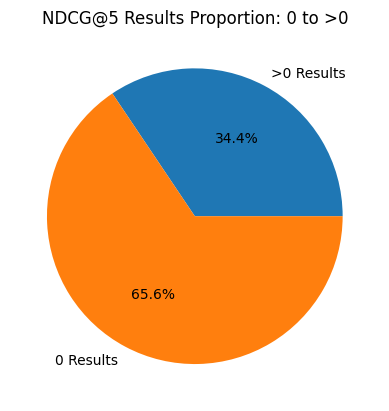

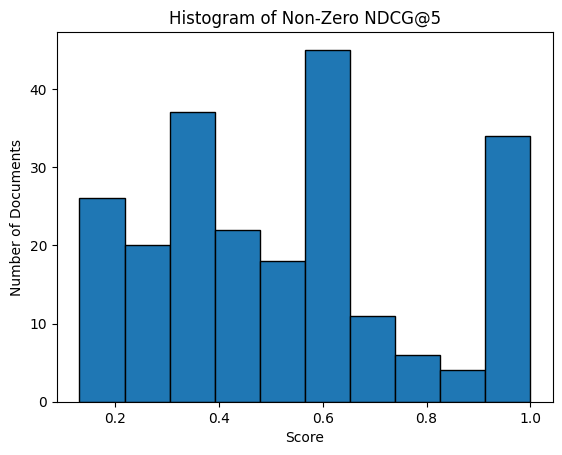

NDCG@5 Mean: 0.1851291130797741 and Std: 0.2968688062149335
NDCG@5 > 0 Mean: 0.5379536559448144 and Std: 0.2574697485799596


In [156]:
fts_size = 5
ndcgs_size = 5

ndcgs_no_rerank = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, all_index_url, 'text', fts_size, ndcgs_size, rerank_nothing)
present_results(ndcgs_no_rerank)

Niestety zastosowanie rerankera tylko pogorszyło wartość metryki NDCG@5.

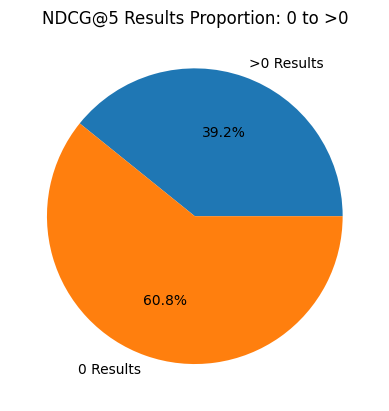

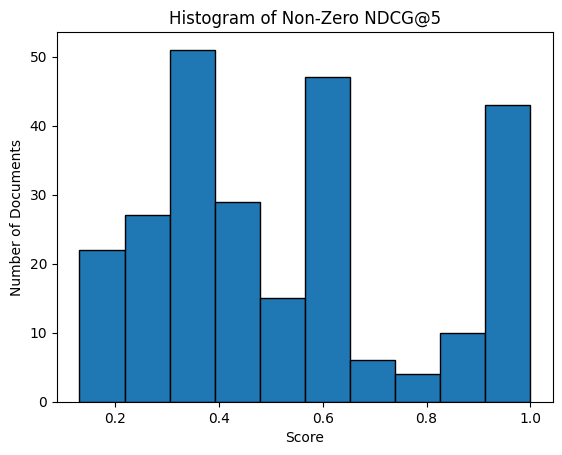

NDCG@5 Mean: 0.2136085613648404 and Std: 0.3129766085063662
NDCG@5 > 0 Mean: 0.5449541250567582 and Std: 0.26330813493663024


In [71]:
fts_size = 10
ndcgs_size = 5

ndcgs_rerank_f1_rand = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, all_index_url, 'text', fts_size, ndcgs_size, rerank)
present_results(ndcgs_rerank_f1_rand)

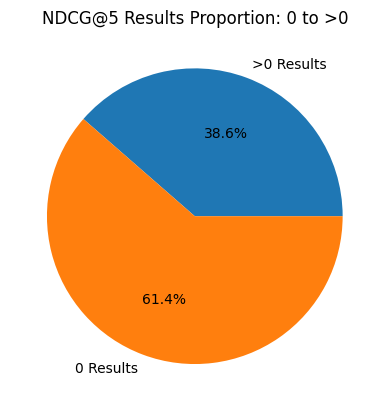

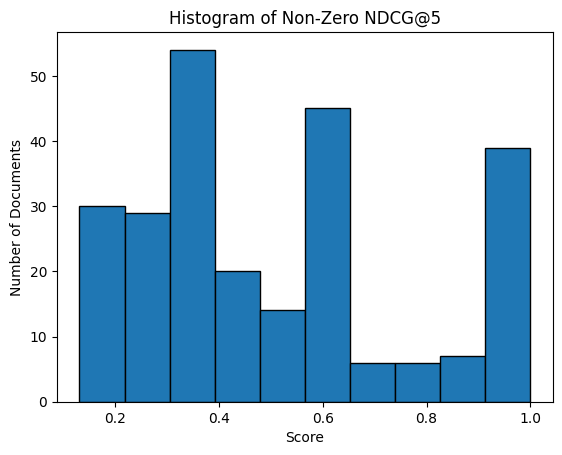

NDCG@5 Mean: 0.20129882201793167 and Std: 0.30223479864742964
NDCG@5 > 0 Mean: 0.5217665466704788 and Std: 0.26374071762919554


In [ ]:
fts_size = 50
ndcgs_size = 5

ndcgs_rerank_f1_rand = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, all_index_url, 'text', fts_size, ndcgs_size, rerank)
present_results(ndcgs_rerank_f1_rand)

In [69]:
import importlib
import lab5_utils
importlib.reload(lab5_utils)

<module 'lab5_utils' from '/Users/mwardynski/Documents/ds/_semestr_9/przetwarzanie_jezyka_naturalnego/labs/lab5/lab5_utils.py'>